# The Library

In [29]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import re
from sklearn import discriminant_analysis
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

# The Necessary Files

In [3]:
current_dir = os.getcwd()
folder = '/data/results_international/'
result_file = 'adj_final_results.csv'
rubicology_file = 'all_games_RWC2023_fixed.csv'

# Expected score gap by elo gap/ relation between elo and score against or for?

In [4]:
result_df = pd.read_csv(current_dir+folder+result_file)
result_df['date'] = pd.to_datetime(result_df['date'])
result_df['point_gap'] = result_df.apply(lambda row: abs(row['Score A']-row['Score B']) , axis=1)
result_df.head(2)

,Unnamed: 0,date,Team A,Team B,Score A,Score B,Tourn,Venue,City,Neut.,Country,elo_home,elo_away,proba_home_win,elo_gap,outcome,point_gap
0,0,1882-12-16,Wales,England,0,2,Home_Nations_Championship,NaN,Swansea,True,NaN,1000.0,1000.00000,0.500000,0.00000,0.0,2
1,1,1883-01-08,Scotland,Wales,3,1,Home_Nations_Championship,NaN,Edinburgh,True,NaN,1000.0,982.97151,0.524486,17.02849,1.0,2


In [5]:
#relationship between point gap and elo gap
result_positive_elo_gap = result_df
result_positive_elo_gap["elo_gap"] = result_positive_elo_gap["elo_gap"].abs()

[Text(0, 0.5, 'Point Gap'), Text(0.5, 0, 'Elo Gap')]

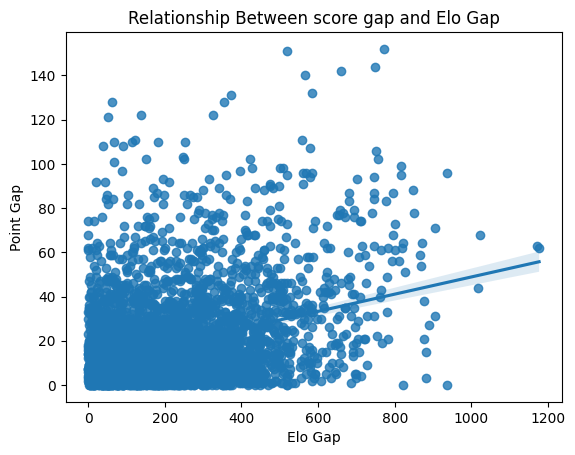

In [6]:
elo_gap_ax = sns.regplot(data=result_positive_elo_gap, y="point_gap", x="elo_gap")
elo_gap_ax.set(title='Relationship Between score gap and Elo Gap')
elo_gap_ax.set(ylabel='Point Gap', xlabel='Elo Gap')

In [7]:
excluded_tournaments = ['Rugby_World_Cup', 'Rugby_World_Cup_Pool_A', 'Rugby_World_Cup_Pool_B', 'Rugby_World_Cup_Pool_C', 'Rugby_World_Cup_Pool_D']

# Filter train data
result_positive_elo_gap_train = result_positive_elo_gap[
    (~result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year != 2023)
]

# Filter test data
result_positive_elo_gap_test = result_positive_elo_gap[
    (result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year == 2023)
]
#estimate point gap
X = np.array(result_positive_elo_gap_train['elo_gap']).reshape(-1,1)
y= np.array(result_positive_elo_gap_train['point_gap']).reshape(-1,1)
X_test = np.array(result_positive_elo_gap_test['elo_gap']).reshape(-1,1)
Y_test = np.array(result_positive_elo_gap_test['point_gap']).reshape(-1,1)
predict_score_gap = LinearRegression().fit(X, y)

<Axes: xlabel='elo_gap', ylabel='Count'>

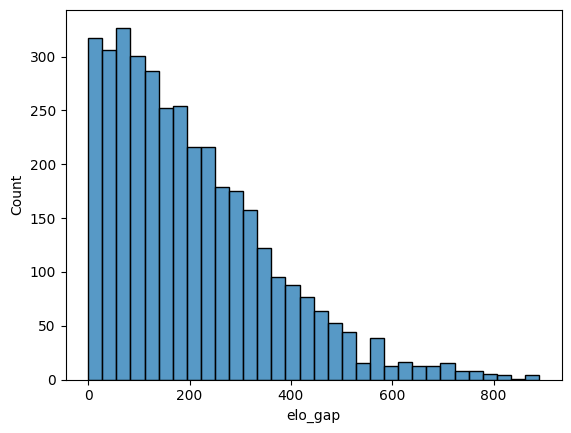

In [8]:
#plot the elo gaps
sns.histplot(data=result_positive_elo_gap_train, x='elo_gap')

In [9]:
#evaluate models
predicted_y = predict_score_gap.predict(X)
predicted_y_test = predict_score_gap.predict(X_test)
mse = 0
for i in range(len(X)):
    mse += (predicted_y[i] - y[i])**2
    mse = mse/len(X)
print(f'mse: {mse}')
result_positive_elo_gap_train['predicted_gap'] = predicted_y
result_positive_elo_gap_test['predicted_gap'] = predicted_y_test

mse: [0.02084434]


# First exploration: Any upsets?

In [109]:
#Conditions on wins
condition_1 = result_positive_elo_gap_test['elo_gap']>100
condition_2 = (result_positive_elo_gap_test['proba_home_win']<0.5) & (result_positive_elo_gap_test['outcome']>0)
condition_3 = (result_positive_elo_gap_test['proba_home_win']>0.5) & (result_positive_elo_gap_test['outcome']<1)
#conditions on score 
condition_4 = result_positive_elo_gap_test['point_gap'] <result_positive_elo_gap_test['predicted_gap']-7
## we will look at score gap smaller than expectd
upsets = result_positive_elo_gap_test[((condition_1) & (condition_2 |condition_3 )) | (condition_1 & condition_4 ) ]
upsets.head(5)

,Unnamed: 0,date,Team A,Team B,Score A,Score B,Tourn,Venue,City,Neut.,Country,elo_home,elo_away,proba_home_win,elo_gap,outcome,point_gap,predicted_gap
3961,3961,2023-09-08,France,New Zealand,27,13,Rugby_World_Cup_Pool_A,Stade de France,Saint-Denis,True,NaN,1663.837464,1867.245237,0.236691,203.407774,1.0,14,17.294593
3969,3969,2023-09-14,France,Uruguay,27,12,Rugby_World_Cup_Pool_A,Stade Pierre-Mauroy,Villeneuve-d'Ascq,True,NaN,1722.493700,1032.485255,0.981513,690.008445,1.0,15,34.225404
3976,3976,2023-09-17,Australia,Fiji,15,22,Rugby_World_Cup_Pool_C,Stade Geoffroy-Guichard,Saint-Étienne,True,NaN,1518.071955,1380.071845,0.688774,138.000110,0.0,7,15.018795
3979,3979,2023-09-22,Argentina,Samoa,19,10,Rugby_World_Cup_Pool_D,Stade Geoffroy-Guichard,Saint-Étienne,True,NaN,1441.764665,1225.481519,0.776438,216.283146,1.0,9,17.742580
3981,3981,2023-09-23,Georgia,Portugal,18,18,Rugby_World_Cup_Pool_C,Stadium de Toulouse,Toulouse,True,NaN,1402.623506,1094.632526,0.854823,307.990980,0.5,0,20.933467


# PCA Baby

In [11]:
from sklearn import decomposition
from sklearn import datasets

In [113]:

rub_wc_df = pd.read_csv(current_dir+'/data/'+rubicology_file )
variables_start = list(rub_wc_df.columns)
variable_end = []
for variable in variables_start:
     if re.search(r'\sA(?!\S)', variable):
        new_variable = re.sub(r'\sA(?!\S)', ' ', variable)
        variable_end.append(new_variable.strip())
variable_a = ['Date', 'Game ID']
variable_b =  ['Date', 'Game ID']

for variable in variable_end:
    if 'Possession' not in variable:
        variable_a.append(f'{variable} A')
    else:
        one, two = variable.split('  - ')
        one = f'{one} A'
        variable = ' - '.join([one, two])
        variable_a.append(variable)

for variable in variable_end:
    if 'Possession' not in variable:
        variable_b.append(f'{variable} B')
    else:
        one, two = variable.split('  - ')
        one = f'{one} B'
        variable = ' - '.join([one, two])
        variable_b.append(variable)
        

rub_wc_df_a = rub_wc_df[variable_a ]
rub_wc_df_b = rub_wc_df[variable_b ]

rub_wc_df_a.columns = rub_wc_df_a.columns.str.replace(r'\sA(?!\S)', '', regex=True)
rub_wc_df_b.columns = rub_wc_df_b.columns.str.replace(r'\sB(?!\S)', '', regex=True)
split_df = pd.concat([rub_wc_df_a,rub_wc_df_b ])
split_df.to_csv(current_dir+folder+'split_df_teams.csv', index=False)

In [90]:
def do_pca_team(df, n_components=2):
    # Assuming target_names is a list of your categorical target names
    label_encoder = LabelEncoder()
    target_names =df['Team']
    y_encoded = label_encoder.fit_transform(df['Team'])

    pca = decomposition.PCA(n_components)

    X=split_df.drop(columns=['Date','Game ID', 'Team'])

    X_r = pca.fit(X).transform(X)
 
    # Percentage of variance explained for each components
    print(
        "explained variance ratio (first two components): %s"
        % str(pca.explained_variance_ratio_)
    )


    plt.figure()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
              '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
    lw = 2
    
    for color, i, target_name in zip(colors, range(20), target_names):
        plt.scatter(
            X_r[y_encoded == i, 0], X_r[y_encoded == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("PCA of IRIS dataset")
    plt.show()
    
    return pca

def do_lda_team(df, n_components=2):
    label_encoder = LabelEncoder()
    target_names =df['Team']
    y_encoded = label_encoder.fit_transform(df['Team'])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=n_components)
    X_r = lda.fit(X, y_encoded).transform(X)
    
    
    plt.figure()
    for color, i, target_name in zip(colors, range(20), target_names):
        plt.scatter(
            X_r[y_encoded == i, 0], X_r[y_encoded == i, 1], alpha=0.8, color=color, label=target_name
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("LDA of IRIS dataset")
    
    plt.show()
    return lda

explained variance ratio (first two components): [0.89994903 0.04599245]


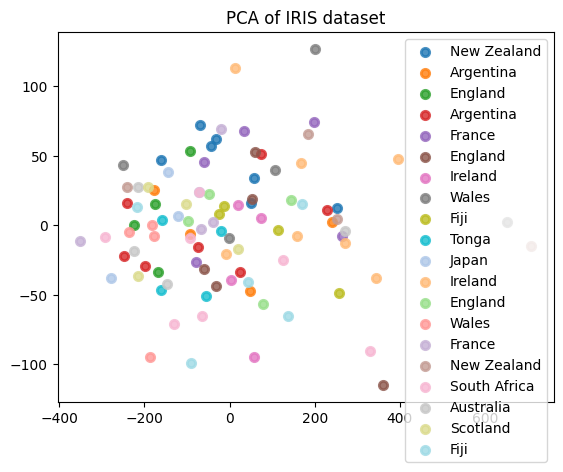

PCA(n_components=2)

In [44]:
do_pca_team(split_df)

In [99]:
#create a df with relatice perfomance: the percentage if each action taken by each team
def create_relative_df(df):
    ids = df['Game ID'].unique()
    for unique_id in ids:
        rows = df[df['Game ID'] == unique_id]
        # sum for each variable across the 2 rows
        sum_row = rows.drop(columns=['Game ID', 'Date', 'Team']).sum(axis=0)
        # divide each row that has the Game ID = id by the sum_rows
        rows.loc[:, ~rows.columns.isin(['Game ID', 'Date', 'Team'])] = rows.drop(columns=['Game ID', 'Date', 'Team']).div(sum_row, axis=1)
        # update the original DataFrame with the scaled values
        df.loc[df['Game ID'] == unique_id, ~df.columns.isin(['Game ID', 'Date', 'Team'])] = rows.drop(columns=['Game ID', 'Date', 'Team']).values
    df.sort_values(by='Game ID', inplace=True)
    df.fillna(0,inplace=True)
    df['Outcome'] = df['Score'].apply(lambda x: 1 if x > 0.5 else (0.5 if x == 0.5 else 0))
    return df

explained variance ratio (first two components): [0.44315771 0.14453358 0.11580279 0.0651747  0.04820507 0.03445406
 0.0265247  0.02357057 0.01963403 0.01776481]


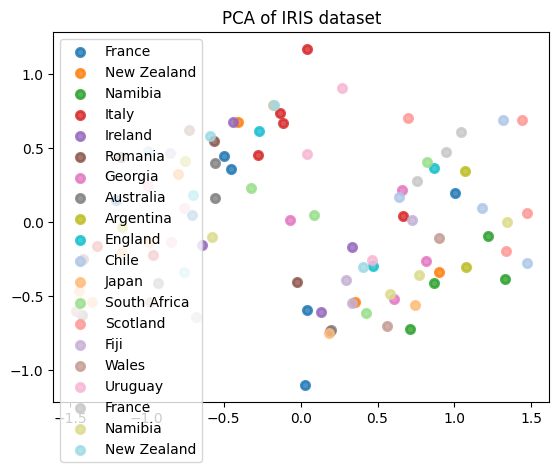

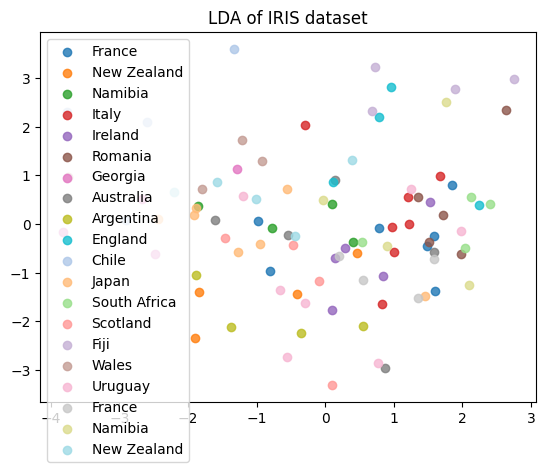

LinearDiscriminantAnalysis(n_components=10)

In [114]:
relative_df = create_relative_df(split_df)
relative_df.to_csv(current_dir+folder+'split_df_relative.csv', index=False)
relative_df_y = relative_df['Outcome']
relative_df_x = relative_df.drop(columns=['Outcome','Score'])
do_pca_team(relative_df_x, 10)
do_lda_team(relative_df_x, 10)

In [ ]:
#split the variable 